In [1]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# retraining the model

In [4]:
X_seq_train = np.load("X_seq_train.npy")
X_seq_val   = np.load("X_seq_val.npy")

X_pam_train = np.load("X_pam_train.npy")
X_pam_val   = np.load("X_pam_val.npy")

X_gene_train = np.load("X_gene_train.npy")
X_gene_val   = np.load("X_gene_val.npy")

X_cut_train = np.load("X_cut_train.npy")
X_cut_val   = np.load("X_cut_val.npy")

y_train = np.load("y_train.npy")
y_val   = np.load("y_val.npy")


In [5]:
class CRISPRDataset(Dataset):
    def __init__(self, X_seq, X_pam, X_gene, X_cut, y):
        self.X_seq = torch.tensor(X_seq, dtype=torch.float32)
        self.X_pam = torch.tensor(X_pam, dtype=torch.float32)
        self.X_gene = torch.tensor(X_gene, dtype=torch.long)   # critical
        self.X_cut = torch.tensor(X_cut, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            "seq": self.X_seq[idx],
            "pam": self.X_pam[idx],
            "gene": self.X_gene[idx],
            "cut": self.X_cut[idx],
            "y": self.y[idx]
        }


In [6]:
train_loader = DataLoader(
    CRISPRDataset(X_seq_train, X_pam_train, X_gene_train, X_cut_train, y_train),
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    CRISPRDataset(X_seq_val, X_pam_val, X_gene_val, X_cut_val, y_val),
    batch_size=64,
    shuffle=False
)


In [7]:
class SequenceCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.pool(x).squeeze(-1)


class GeneEmbedding(nn.Module):
    def __init__(self, num_genes, embed_dim=6):
        super().__init__()
        self.embed = nn.Embedding(num_genes, embed_dim)

    def forward(self, x):
        return self.embed(x)


class PAMProjector(nn.Module):
    def __init__(self, pam_dim, out_dim=4):
        super().__init__()
        self.fc = nn.Linear(pam_dim, out_dim)

    def forward(self, x):
        return F.relu(self.fc(x))


class CRISPRAggregateModel(nn.Module):
    def __init__(self, num_genes, pam_dim):
        super().__init__()
        self.seq_branch = SequenceCNN()
        self.gene_branch = GeneEmbedding(num_genes)
        self.pam_branch = PAMProjector(pam_dim)

        self.regressor = nn.Sequential(
            nn.Linear(64 + 6 + 4 + 1, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, seq, pam, gene, cut):
        x = torch.cat([
            self.seq_branch(seq),
            self.gene_branch(gene),
            self.pam_branch(pam),
            cut
        ], dim=1)
        return self.regressor(x)


In [8]:
with open("gene2id.json") as f:
    num_genes = len(json.load(f))

pam_dim = X_pam_train.shape[1]

model = CRISPRAggregateModel(num_genes, pam_dim).to(device)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [10]:
def train_one_epoch(model, loader):
    model.train()
    losses = []
    for batch in loader:
        optimizer.zero_grad()
        preds = model(
            batch["seq"].to(device),
            batch["pam"].to(device),
            batch["gene"].to(device),
            batch["cut"].to(device)
        )
        loss = criterion(preds, batch["y"].to(device))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)


def evaluate(model, loader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for batch in loader:
            pred = model(
                batch["seq"].to(device),
                batch["pam"].to(device),
                batch["gene"].to(device),
                batch["cut"].to(device)
            )
            ys.append(batch["y"].cpu().numpy())
            preds.append(pred.cpu().numpy())
    return mean_squared_error(
        np.vstack(ys), np.vstack(preds)
    )


In [11]:
num_epochs = 25

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    tr_loss = train_one_epoch(model, train_loader)
    va_loss = evaluate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train MSE: {tr_loss:.4f} | "
        f"Val MSE: {va_loss:.4f}"
    )


Epoch 01 | Train MSE: 0.1425 | Val MSE: 0.0778
Epoch 02 | Train MSE: 0.0901 | Val MSE: 0.0726
Epoch 03 | Train MSE: 0.0812 | Val MSE: 0.0673
Epoch 04 | Train MSE: 0.0732 | Val MSE: 0.0598
Epoch 05 | Train MSE: 0.0662 | Val MSE: 0.0527
Epoch 06 | Train MSE: 0.0570 | Val MSE: 0.0452
Epoch 07 | Train MSE: 0.0499 | Val MSE: 0.0383
Epoch 08 | Train MSE: 0.0423 | Val MSE: 0.0334
Epoch 09 | Train MSE: 0.0383 | Val MSE: 0.0293
Epoch 10 | Train MSE: 0.0349 | Val MSE: 0.0265
Epoch 11 | Train MSE: 0.0334 | Val MSE: 0.0241
Epoch 12 | Train MSE: 0.0307 | Val MSE: 0.0224
Epoch 13 | Train MSE: 0.0310 | Val MSE: 0.0225
Epoch 14 | Train MSE: 0.0284 | Val MSE: 0.0207
Epoch 15 | Train MSE: 0.0266 | Val MSE: 0.0193
Epoch 16 | Train MSE: 0.0261 | Val MSE: 0.0200
Epoch 17 | Train MSE: 0.0254 | Val MSE: 0.0175
Epoch 18 | Train MSE: 0.0231 | Val MSE: 0.0165
Epoch 19 | Train MSE: 0.0224 | Val MSE: 0.0158
Epoch 20 | Train MSE: 0.0201 | Val MSE: 0.0153
Epoch 21 | Train MSE: 0.0207 | Val MSE: 0.0149
Epoch 22 | Tr

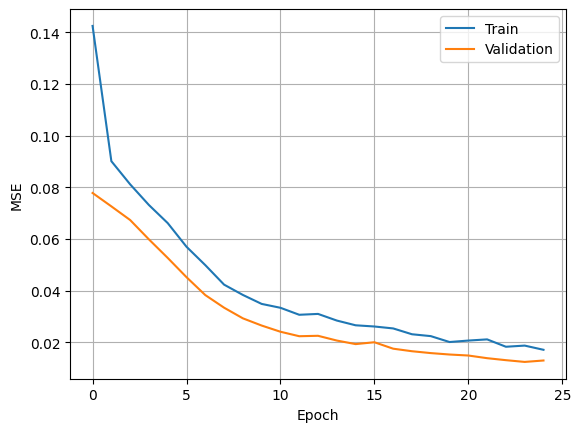

In [13]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.savefig("Train_vs_val_MSE_plot_day13.png")
plt.show()


In [14]:
X_seq_test  = np.load("X_seq_test.npy")
X_pam_test  = np.load("X_pam_test.npy")
X_gene_test = np.load("X_gene_test.npy")
X_cut_test  = np.load("X_cut_test.npy")
y_test      = np.load("y_test.npy")

In [15]:
test_loader = DataLoader(
    CRISPRDataset(X_seq_test, X_pam_test, X_gene_test, X_cut_test, y_test),
    batch_size=64,
    shuffle=False
)

In [20]:
# running train model on test set
model.eval()

y_true_scaled = []
y_pred_scaled = []

with torch.no_grad():
  for batch in test_loader:
    preds = model(
        batch["seq"].to(device),
        batch["pam"].to(device),
        batch["gene"].to(device),
        batch["cut"].to(device)
    )

    y_pred_scaled.append(preds.cpu().numpy())
    y_true_scaled.append(batch["y"].cpu().numpy())

y_true_scaled = np.vstack(y_true_scaled).flatten()
y_pred_scaled = np.vstack(y_pred_scaled).flatten()

In [21]:
# compute test metrics
mse_scaled = mean_squared_error(y_true_scaled, y_pred_scaled)
mae_scaled = mean_absolute_error(y_true_scaled, y_pred_scaled)
r2_scaled = r2_score(y_true_scaled, y_pred_scaled)

print(f"Scaled MSE: {mse_scaled:.4f}")
print(f"Scaled MAE: {mae_scaled:.4f}")
print(f"Scaled R^2: {r2_scaled:.4f}")

Scaled MSE: 0.0142
Scaled MAE: 0.0836
Scaled R^2: 0.8332


In [19]:
y_min = np.load("y_scaler_min.npy")[0]
y_max = np.load("y_scaler_max.npy")[0]

print("Percent Peptide range in dataset:")
print("Min:", y_min)
print("Max:", y_max)

Percent Peptide range in dataset:
Min: 0.05
Max: 99.82


In [22]:
# mapping scaled values back to experimental units
y_true_real = y_true_scaled * (y_max - y_min) + y_min
y_pred_real = y_pred_scaled * (y_max - y_min) + y_min

In [23]:
mae_real = mean_absolute_error(y_true_real, y_pred_real)
mse_real = mean_squared_error(y_true_real, y_pred_real)
r2_real = r2_score(y_true_real, y_pred_real)

print(f"Real MSE: {mse_real:.4f}")
print(f"Real MAE: {mae_real:.4f}")
print(f"Real R^2: {r2_real:.4f}")

Real MSE: 141.2724
Real MAE: 8.3400
Real R^2: 0.8332


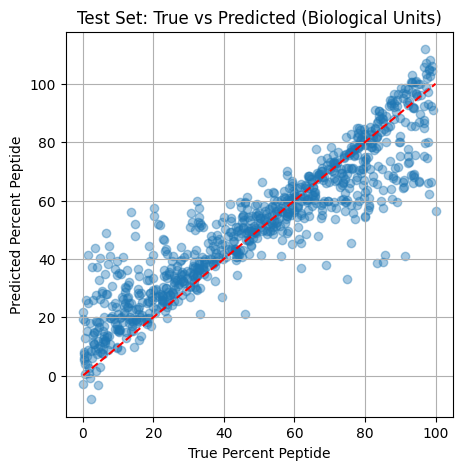

In [24]:
# True vs Predicted (Percent Peptide) plot

plt.figure(figsize = (5, 5))
plt.scatter(y_true_real, y_pred_real, alpha = 0.4)
plt.plot(
    [y_true_real.min(), y_true_real.max()],
    [y_true_real.min(), y_true_real.max()],
    "r--"
)

plt.xlabel("True Percent Peptide")
plt.ylabel("Predicted Percent Peptide")
plt.grid(True)
plt.title("Test Set: True vs Predicted (Biological Units)")
plt.savefig("True_vs_pred_percent_peptide_plot_day13.png")
plt.show()

In [25]:
# lightweight ablations

In [26]:
#reusable evaluation helper

def evaluate_on_arrays(model, X_seq, X_pam, X_gene, X_cut, y_scaled):
  """evaluate model on given arrays, return metrics + predictions."""

  loader = DataLoader(
      CRISPRDataset(X_seq, X_pam, X_gene, X_cut, y_scaled),
      batch_size=64,
      shuffle=False
  )

  model.eval()
  y_true_list, y_pred_list = [], []

  with torch.no_grad():
    for batch in loader:
      preds = model(
          batch["seq"].to(device),
          batch["pam"].to(device),
          batch["gene"].to(device),
          batch["cut"].to(device)
      )

      y_pred_list.append(preds.cpu().numpy())
      y_true_list.append(batch["y"].cpu().numpy())

  y_true = np.vstack(y_true_list).flatten()
  y_pred = np.vstack(y_pred_list).flatten()

  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  return mse, mae, r2, y_true, y_pred

In [27]:
mse_base, mae_base, r2_base, _, _ = evaluate_on_arrays(
    model,
    X_seq_test,
    X_pam_test,
    X_gene_test,
    X_cut_test,
    y_test
)

print("Baseline (no ablation) – scaled:")
print(f"MSE: {mse_base:.4f}, MAE: {mae_base:.4f}, R²: {r2_base:.4f}")

Baseline (no ablation) – scaled:
MSE: 0.0142, MAE: 0.0836, R²: 0.8332


In [28]:
# Abalation 1: Shuffle Gene IDs

np.random.seed(42)

X_gene_shuffled = X_gene_test.copy()
np.random.shuffle(X_gene_shuffled)

mse_g, mae_g, r2_g, _, _ = evaluate_on_arrays(
    model,
    X_seq_test,
    X_pam_test,
    X_gene_shuffled,
    X_cut_test,
    y_test
)

print("gene-shuffled ablation - scaled:")
print(f"MSE: {mse_g:.4f}, MAE: {mae_g:.4f}, R²: {r2_g:.4f}")

gene-shuffled ablation - scaled:
MSE: 0.0958, MAE: 0.2446, R²: -0.1258


In [32]:
# Ablation2: Neutralize PAM
pam_counts = X_pam_test.sum(axis=0)
pam_mode_idx = np.argmax(pam_counts)
pam_mode_idx

np.int64(3)

In [33]:
X_pam_const = np.zeros_like(X_pam_test)
X_pam_const[:, pam_mode_idx] = 1.0 # everyone gets same PAM


In [34]:
mse_p, mae_p, r2_p, _, _ = evaluate_on_arrays(
    model,
    X_seq_test,
    X_pam_const,
    X_gene_test,
    X_cut_test,
    y_test
)

print("pam-neutralized ablation - scaled:")
print(f"MSE: {mse_p:.4f}, MAE: {mae_p:.4f}, R²: {r2_p:.4f}")

pam-neutralized ablation - scaled:
MSE: 0.0145, MAE: 0.0850, R²: 0.8299


In [35]:
# Ablation 3: Neutralize Cut Position

cut_mean = X_cut_test.mean()
X_cut_const = np.full_like(X_cut_test, cut_mean)

mse_c, mae_c, r2_c, _, _ = evaluate_on_arrays(
    model,
    X_seq_test,
    X_pam_test,
    X_gene_test,
    X_cut_const,
    y_test
)

print("cut-neutralized ablation - scaled:")
print(f"MSE: {mse_c:.4f}, MAE: {mae_c:.4f}, R²: {r2_c:.4f}")

cut-neutralized ablation - scaled:
MSE: 0.1283, MAE: 0.2987, R²: -0.5077


In [36]:
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": num_epochs,
    "test_metrics": {
        "scaled": {
            "MSE": mse_scaled,
            "MAE": mae_scaled,
            "R2": r2_scaled
        },
        "real_units": {
            "MAE_percent_points": mae_real,
            "R2": r2_real
        }
    },
    "notes": (
        "Day 12–13 context-aware CRISPR model. "
        "Multi-input architecture integrating sgRNA sequence, "
        "gene embedding, PAM, and cut position. "
        "Checkpoint saved after test-set evaluation and ablation analysis."
    )
}

torch.save(checkpoint, "final_model_day12_and_13.pth")